# HMM on real data (*MSCI World*)
This notebook showcases practical applications on real data.

## Importing Libraries
We start by importing the necessary libraries for the operations ahead.

In [1]:
import os
os.chdir('../')

from inference_mahmm import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

## Data Importation and Visualization

We begin by importing and exploring the dataset. We select observations of the *MSCI Europe Index* (Bloomberg code: NDDUE15) from December 31, 1999 to the most recents data (May 31, 2023). We split our data between training and test on December 31, 2014.

In [2]:
valeur, code = 'MSCI World', 'MSWRLD$'
date_start, date_is_oos = '31/12/1999', '31/12/2014'
K, L = 3, 0

DATA = data(code, date_start, date_is_oos, L, '/Users/eleonore/Documents/GitHub/Inference_nMA-HMM/Data/data.csv')

### Markov Chain $Y$ of Observations
The Markov chain $Y$ of observations is normally distributed with parameters depending on the state of the unobserved process $X$:

$$y_t = f(x_t \vert \mu_{x_t}, \sigma_{x_t}) \quad \forall t \in [0, T]$$

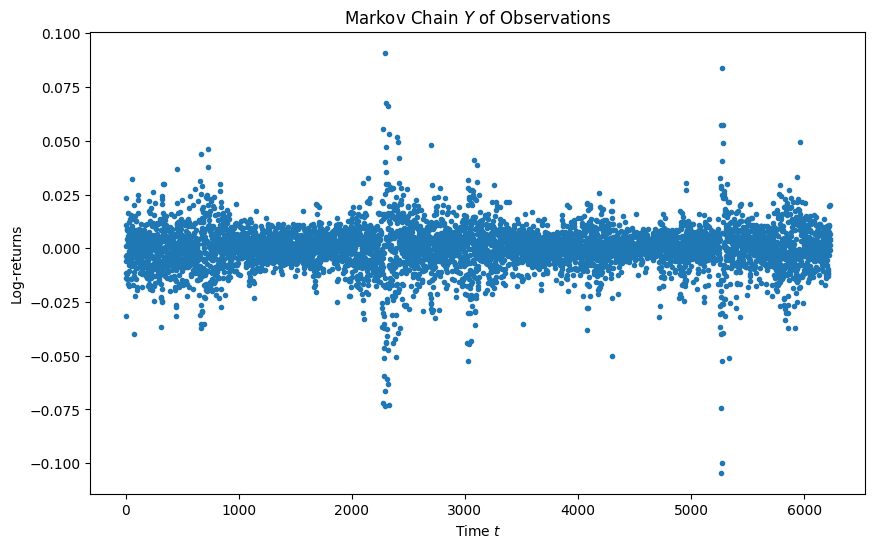

In [3]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(DATA.log_ret, '.')
plt.title('Markov Chain $Y$ of Observations')
plt.ylabel('Log-returns')
plt.xlabel('Time $t$')
plt.show()

### Histogram of the data
Then, we vizualize the data by plotting its histogram.

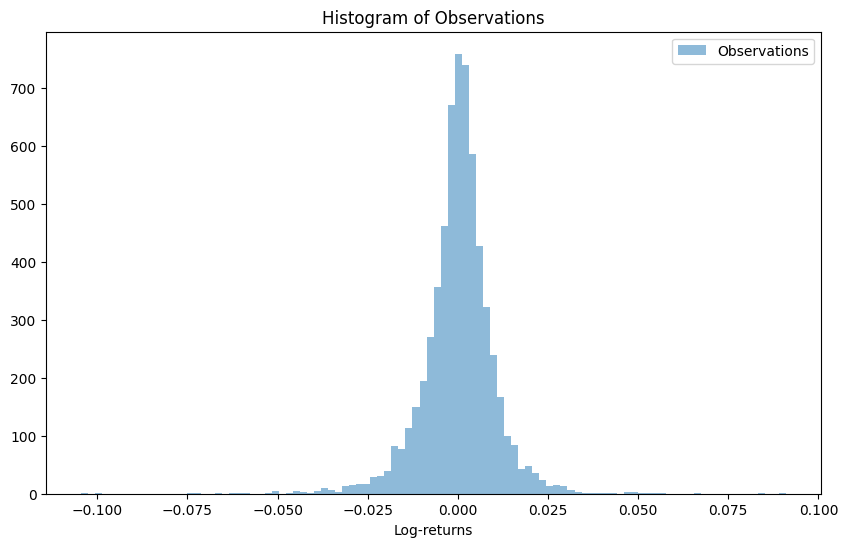

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(DATA.log_ret, bins=100, label='Observations', alpha=.5)
plt.title('Histogram of Observations')
plt.xlabel('Log-returns')
plt.legend(loc=1)
plt.show()

### Price Trajectories
Finally, from the returns, we can calculate the resulting price trajectories.

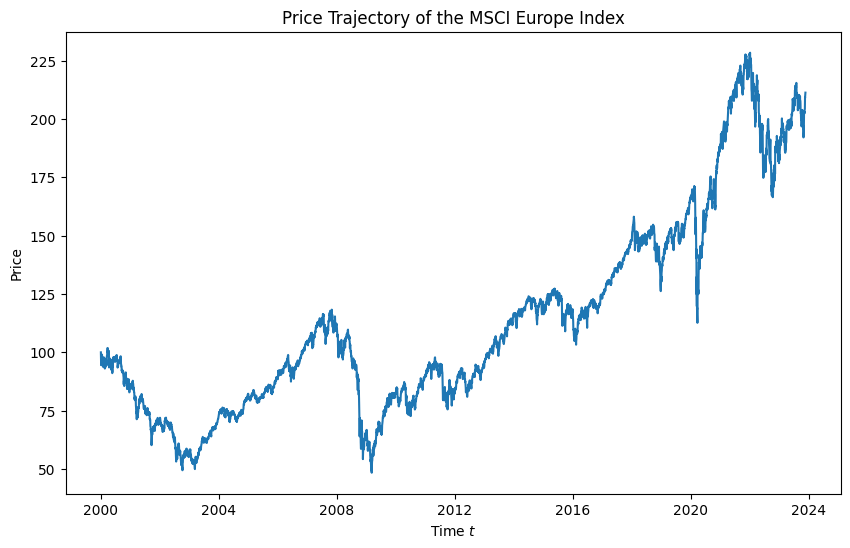

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(DATA.date, compute_price(DATA.log_ret))
plt.title('Price Trajectory of the MSCI Europe Index')
plt.xlabel('Time $t$')
plt.ylabel('Price')
plt.show()

## Gibbs Sampling and Parameter Estimation
This part performs Gibbs sampling to estimate parameters. `n_iter` and `n_burnin` are set for the number of iterations and burn-in period, respectively.

The Gibbs sampler consist in alternating the estimation and updating of the parameters of the model conditionally with the observations and the latent states and the estimation and updating of the unobserved Markov chain conditionally with the observations and the parameters of the model.

### HMM

In [6]:
g = gibbs(K, 0, len(DATA.log_ret_is)/len(DATA.log_ret), DATA.log_ret)
n_iter, n_burnin = 1500, 500
g.algorithm_est_ma(n_iter, n_burnin)   

  0%|          | 0/1500 [00:00<?, ?it/s]

### Parameters Estimation Results
We compare the estimated parameters ($M$, $\Sigma$, $\nu$, $Q$)

In [7]:
print('Est. M (HMM) :\n', np.mean(np.array([g.res[k]['M'] for k in g.res.keys()]), axis=0))
print('\nEst. Σ (HMM) :\n', np.mean(np.array([g.res[k]['Σ'] for k in g.res.keys()]), axis=0))
print('\nEst. Q (HMM) :\n', np.mean(np.array([g.res[k]['Q'] for k in g.res.keys()]), axis=0))
print('\nEst. ν (HMM) :\n', np.mean(np.array([g.res[k]['ν'] for k in g.res.keys()]), axis=0))

Est. M (HMM) :
 [-0.0017694  -0.00023362  0.00074812]

Est. Σ (HMM) :
 [0.01052927 0.0054495  0.02387828]

Est. Q (HMM) :
 [[9.72821287e-01 2.04732678e-02 6.70544571e-03]
 [1.76479204e-02 9.81699250e-01 6.52830024e-04]
 [3.17820875e-02 3.59201983e-03 9.64625893e-01]]

Est. ν (HMM) :
 [0.42531503 0.48365088 0.09103409]


### Posterior Predictive Distribution
We visualize the posterior predictive distribution, which is the probability distribution that estimates future observations based on both the observed data and the uncertainty in model parameters in Bayesian statistics. It combines information from the data (observations) and the model (HMM) to provide a range of possible future outcomes.

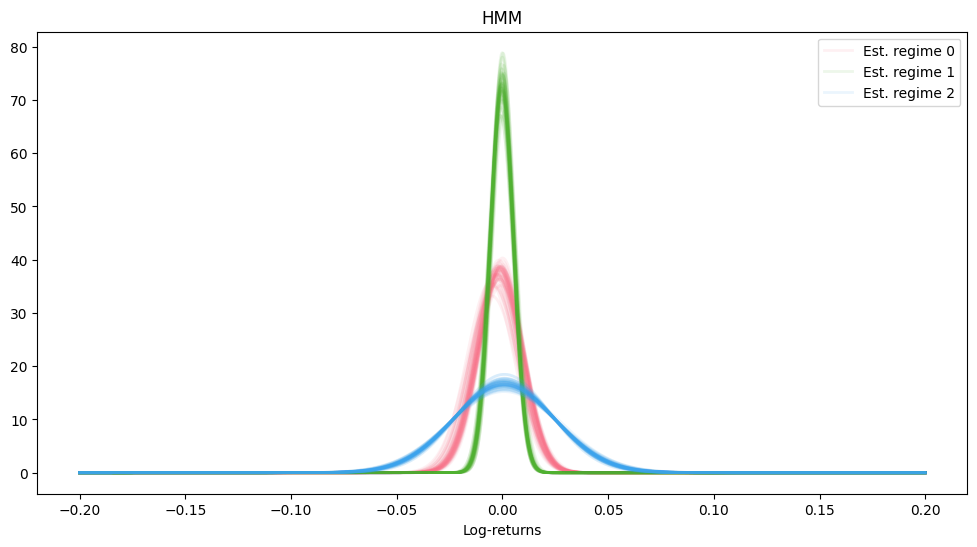

In [8]:
palette = sns.color_palette("husl", 3)

fig, ax = plt.subplots(figsize=(12,6))

x_pdf = np.arange(-.2, .2, 0.0001)
for k in range(K):
    for key in list(g.res.keys())[-50:]:
        plt.plot(x_pdf, norm.pdf(x_pdf, g.res[key]['M'][k], g.res[key]['Σ'][k]), color=palette[k], linewidth=2, label='Est. regime ' + str(k), alpha=.1)    
plt.title('HMM')
plt.xlabel('Log-returns')
legend_entries = [plt.Line2D([0], [0], color=palette[k], lw=2, alpha=0.1) for k in range(K)]
plt.legend(legend_entries, ['Est. regime ' + str(k) for k in range(K)])

### State Decoding Results
This section visualizes the results of the states decoding:
* the **in-sample decoding**, in the training period
* the **out-of-sample decoding**, in the test period

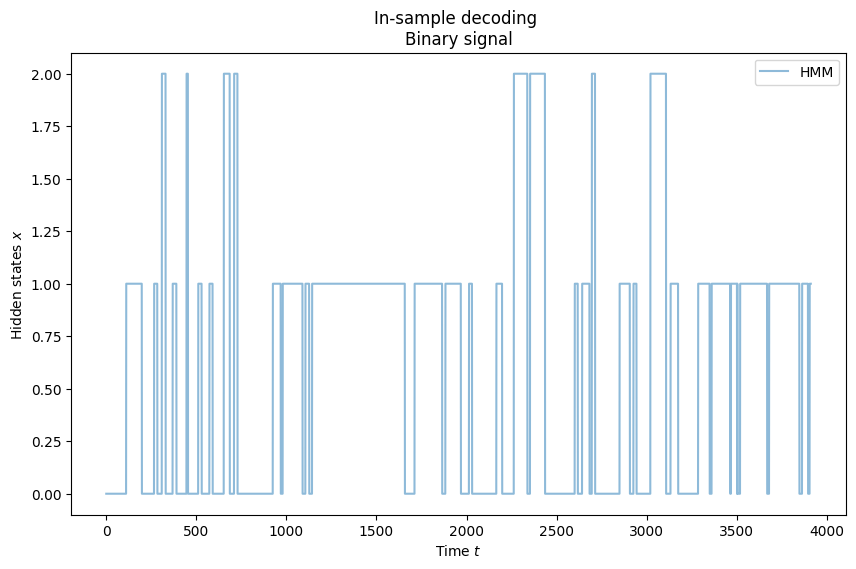

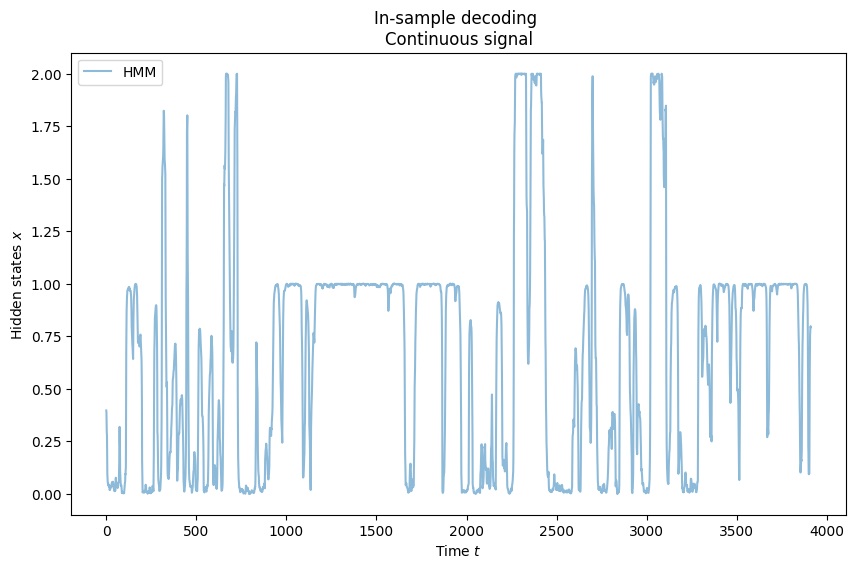

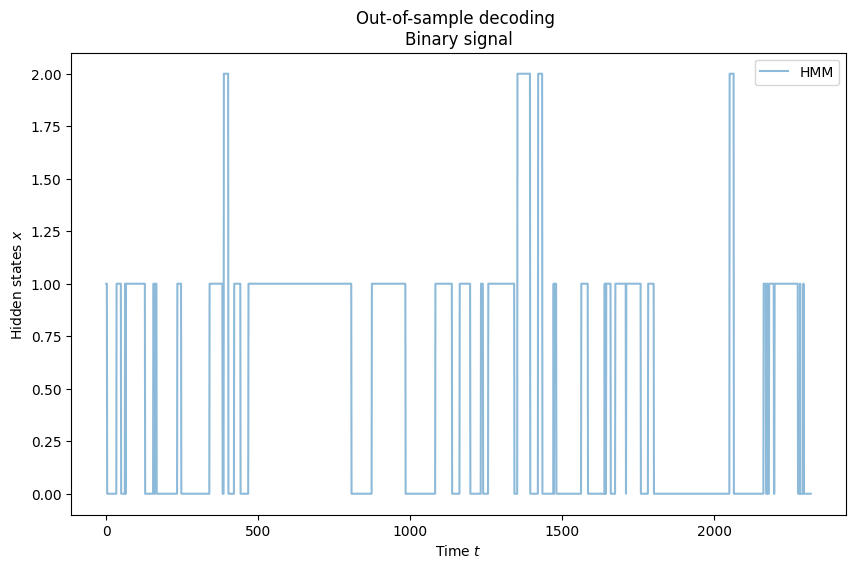

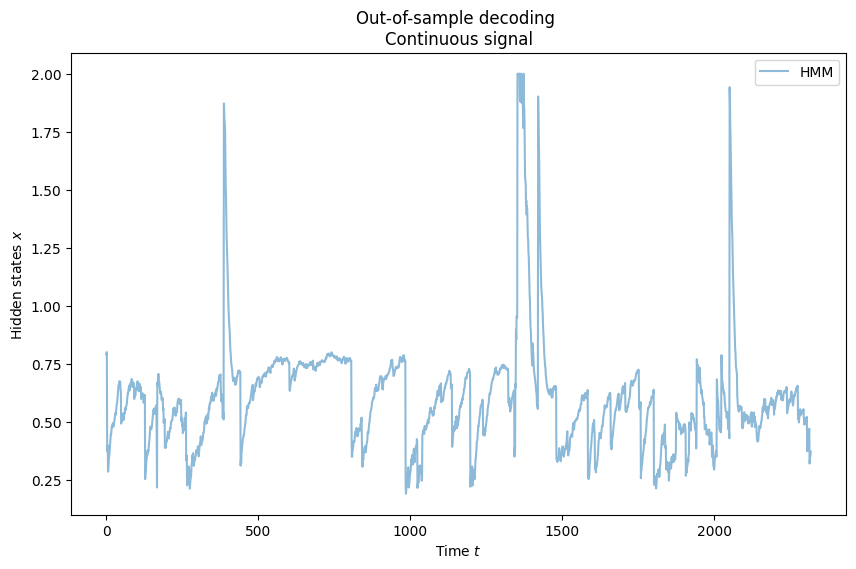

In [9]:
x_all_is = np.array([g.res[k]['x_is'] for k in g.res.keys()])
x_is = np.array([np.argmax(np.bincount(column)) for column in x_all_is.T.astype(int)])
x_is_cont = np.mean(x_all_is, axis=0)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_is, label='HMM', alpha=.5)
plt.title('In-sample decoding \nBinary signal')
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.legend(loc=1)
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_is_cont, label='HMM', alpha=.5)
plt.title('In-sample decoding \nContinuous signal')
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.legend(loc=2)
plt.show()

x_all_oos = np.array([g.res[k]['x_oos'][-len(DATA.log_ret_oos):] for k in g.res.keys()])
x_oos = np.array([np.argmax(np.bincount(column)) for column in x_all_oos.T.astype(int)])
x_oos_cont = np.mean(x_all_oos, axis=0)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_oos, label='HMM', alpha=.5)
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.title('Out-of-sample decoding \nBinary signal')
plt.legend(loc=1)
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_oos_cont, label='HMM', alpha=.5)
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.title('Out-of-sample decoding \nContinuous signal')
plt.legend(loc=1)
plt.show()